<a href="https://colab.research.google.com/github/Sooraj-z/Brain-Tumor-Classification/blob/main/brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q efficientnet_pytorch

import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(10, translate=(0.1, 0.1)),
    transforms.ColorJitter(0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

# Define path
train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# Advanced augmentation (Gaussian noise, rotation, etc.)
def add_gaussian_noise(tensor):
    noise = torch.randn_like(tensor) * 0.02
    return tensor + noise

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Lambda(add_gaussian_noise),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load full training set and split into train/val
full_train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset.transform = test_transforms  # Apply cleaner transforms for val

# Load untouched test set
test_dataset = ImageFolder(test_dir, transform=test_transforms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = full_train_dataset.classes
print("Classes:", class_names)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetClassifier, self).__init__()
        self.base = EfficientNet.from_pretrained('efficientnet-b0')
        in_features = self.base._fc.in_features
        self.base._fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(0.4),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base(x)

# Set device and instantiate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetClassifier(num_classes=len(class_names)).to(device)

# Full fine-tuning: no frozen layers
for param in model.parameters():
    param.requires_grad = True

Loaded pretrained weights for efficientnet-b0


In [ ]:
# Label smoothing for better generalization
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, eps=0.1):
        super().__init__()
        self.eps = eps
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, output, target):
        log_probs = self.log_softmax(output)
        targets = torch.zeros_like(log_probs).scatter_(1, target.unsqueeze(1), 1)
        targets = (1 - self.eps) * targets + self.eps / log_probs.size(1)
        return (-targets * log_probs).sum(dim=1).mean()

# Criterion
criterion = LabelSmoothingCrossEntropy(eps=0.1)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Cosine Annealing Scheduler (smoother than ReduceLROnPlateau)
num_epochs = 20
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
class EarlyStopper:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')

    def step(self, current_loss):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

In [ ]:
from tqdm import tqdm

early_stopper = EarlyStopper(patience=3)
scaler = torch.amp.GradScaler("cuda" if torch.cuda.is_available() else "cpu")

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast("cuda" if torch.cuda.is_available() else "cpu"):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.amp.autocast("cuda" if torch.cuda.is_available() else "cpu"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)
    scheduler.step()

    print(f"\nEpoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "efficientnet_b0_best.pth")
        print("Saved New Best Model\n")

    if early_stopper.step(avg_val_loss):
        print("Early stopping triggered. Training halted.")
        break


Epoch 1/20 | Train Loss: 0.7371 | Train Acc: 0.8044 | Val Loss: 0.8284 | Val Acc: 0.7399
Saved New Best Model




Epoch 2/20 | Train Loss: 0.5077 | Train Acc: 0.9381 | Val Loss: 0.6916 | Val Acc: 0.8205
Saved New Best Model




Epoch 3/20 | Train Loss: 0.4642 | Train Acc: 0.9602 | Val Loss: 0.5990 | Val Acc: 0.8879
Saved New Best Model




Epoch 4/20 | Train Loss: 0.4395 | Train Acc: 0.9742 | Val Loss: 0.5082 | Val Acc: 0.9413
Saved New Best Model




Epoch 5/20 | Train Loss: 0.4216 | Train Acc: 0.9834 | Val Loss: 0.4466 | Val Acc: 0.9711
Saved New Best Model




Epoch 6/20 | Train Loss: 0.4136 | Train Acc: 0.9906 | Val Loss: 0.4150 | Val Acc: 0.9781
Saved New Best Model




Epoch 7/20 | Train Loss: 0.4072 | Train Acc: 0.9912 | Val Loss: 0.4056 | Val Acc: 0.9842
Saved New Best Model




Epoch 8/20 | Train Loss: 0.4000 | Train Acc: 0.9934 | Val Loss: 0.3996 | Val Acc: 0.9869
Saved New Best Model




Epoch 9/20 | Train Loss: 0.4012 | Train Acc: 0.9932 | Val Loss: 0.3947 | Val Acc: 0.9877
Saved New Best Model




Epoch 10/20 | Train Loss: 0.3972 | Train Acc: 0.9947 | Val Loss: 0.3948 | Val Acc: 0.9877



Epoch 11/20 | Train Loss: 0.3892 | Train Acc: 0.9969 | Val Loss: 0.3939 | Val Acc: 0.9869
Saved New Best Model




Epoch 12/20 | Train Loss: 0.3887 | Train Acc: 0.9967 | Val Loss: 0.3930 | Val Acc: 0.9860
Saved New Best Model




Epoch 13/20 | Train Loss: 0.3875 | Train Acc: 0.9982 | Val Loss: 0.3902 | Val Acc: 0.9869
Saved New Best Model




Epoch 14/20 | Train Loss: 0.3868 | Train Acc: 0.9969 | Val Loss: 0.3902 | Val Acc: 0.9869



Epoch 15/20 | Train Loss: 0.3867 | Train Acc: 0.9969 | Val Loss: 0.3910 | Val Acc: 0.9869



Epoch 16/20 | Train Loss: 0.3849 | Train Acc: 0.9982 | Val Loss: 0.3897 | Val Acc: 0.9877
Saved New Best Model




Epoch 17/20 | Train Loss: 0.3830 | Train Acc: 0.9987 | Val Loss: 0.3898 | Val Acc: 0.9869



Epoch 18/20 | Train Loss: 0.3820 | Train Acc: 0.9987 | Val Loss: 0.3894 | Val Acc: 0.9869
Saved New Best Model




Epoch 19/20 | Train Loss: 0.3864 | Train Acc: 0.9965 | Val Loss: 0.3891 | Val Acc: 0.9869
Saved New Best Model




Epoch 20/20 | Train Loss: 0.3836 | Train Acc: 0.9972 | Val Loss: 0.3891 | Val Acc: 0.9869



Test Accuracy: 0.9893
              Class Precision  Recall  F1-Score  Support
0            glioma    0.9966  0.9867    0.9916      300
1        meningioma     0.974  0.9804    0.9772      306
2           notumor    0.9902  0.9951    0.9926      405
3         pituitary    0.9967  0.9933    0.9950      300
4  Overall Accuracy                      0.9893     1311


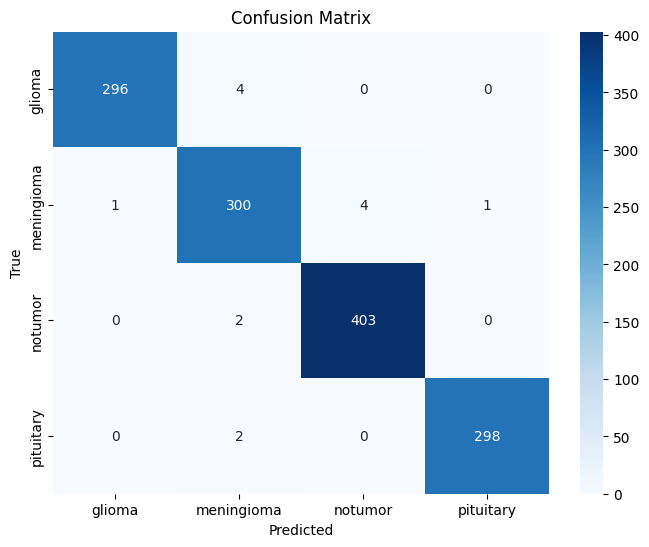

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load best model
model.load_state_dict(torch.load("efficientnet_b0_best.pth"))
model.eval()

# Inference on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc:.4f}")

# Classification Report (as DataFrame with 4 decimals)
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, labels=list(range(len(class_names)))
)

report_df = pd.DataFrame({
    "Class": class_names,
    "Precision": np.round(precision, 4),
    "Recall": np.round(recall, 4),
    "F1-Score": np.round(f1, 4),
    "Support": support
})

# Add overall accuracy row
report_df.loc[len(report_df)] = ["Overall Accuracy", "", "", np.round(acc, 4), sum(support)]
print(report_df)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

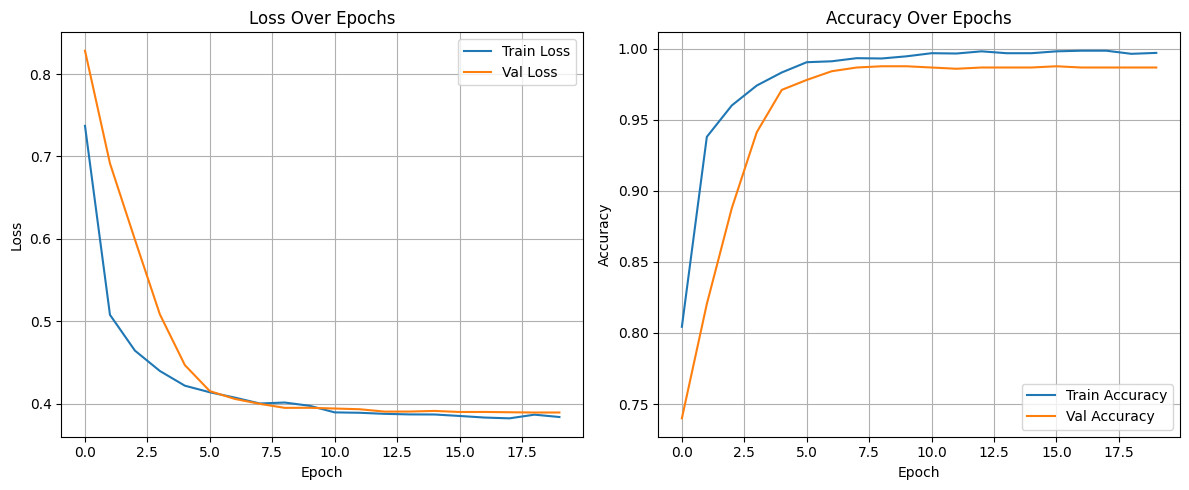

In [ ]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

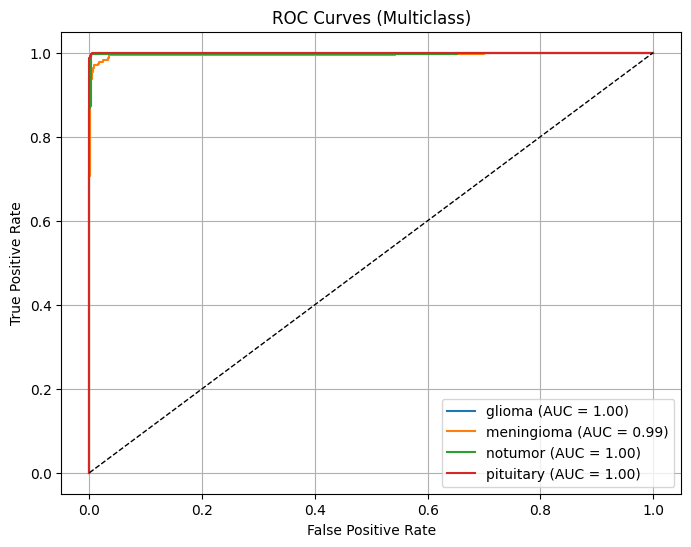

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Binarize labels
y_true_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
y_scores = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_scores.append(outputs.cpu().numpy())

y_scores = np.concatenate(y_scores, axis=0)

# Plot ROC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("ROC Curves (Multiclass)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
!pip install -q grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import random, cv2, numpy as np

# Grad-CAM layer target
target_layers = [model.base._blocks[-1]._project_conv]
cam = GradCAM(model=model, target_layers=target_layers)

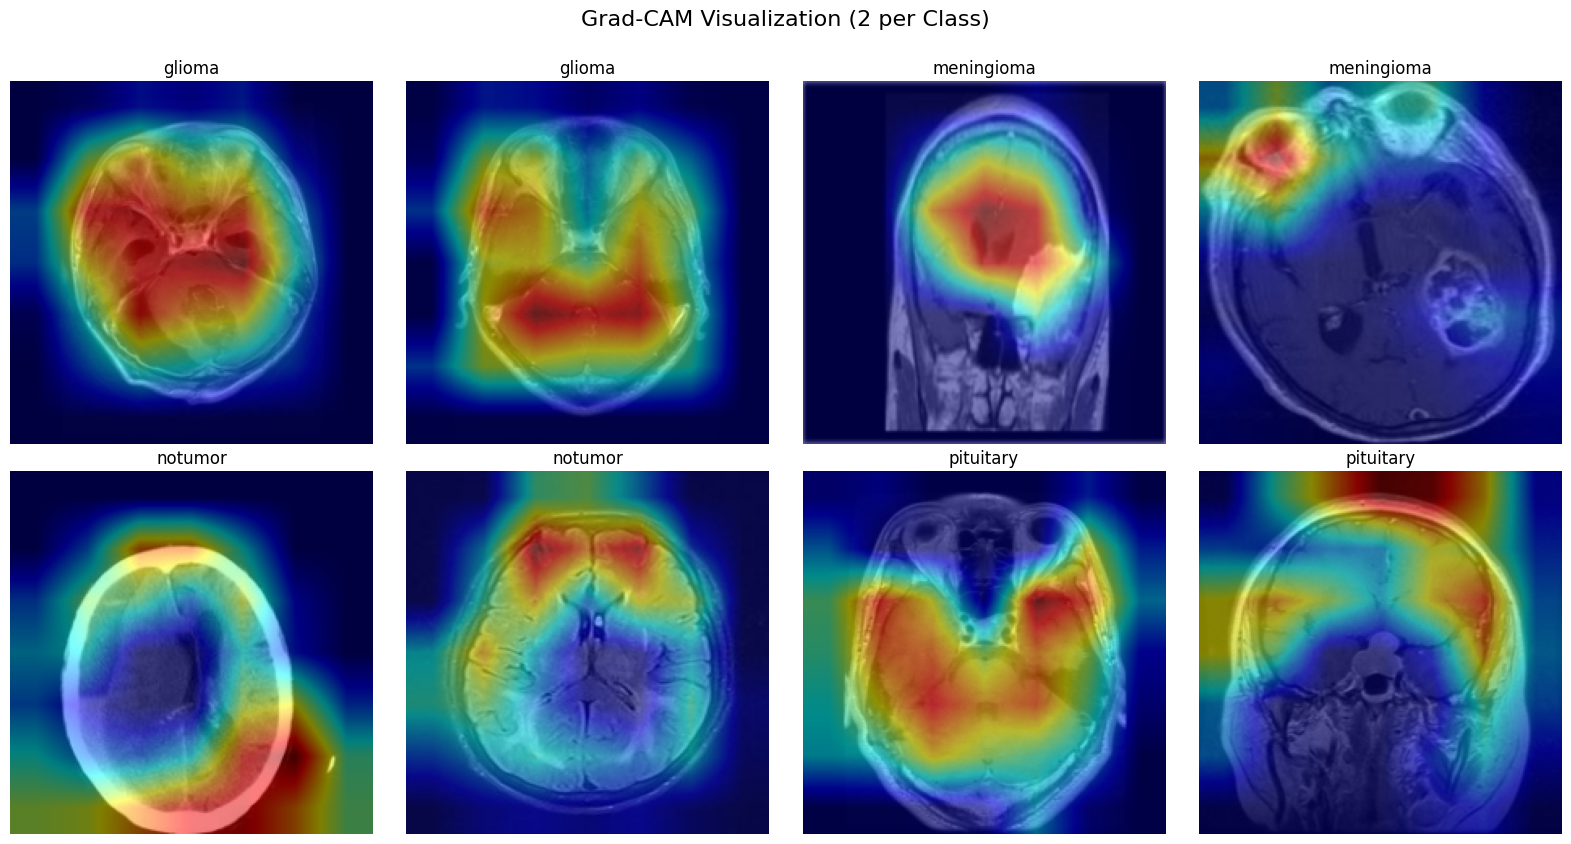

In [ ]:
# Organize test samples by class
samples_by_class = {i: [] for i in range(len(class_names))}

# Collect 2 per class
for images, labels in test_loader:
    for img, label in zip(images, labels):
        if len(samples_by_class[label.item()]) < 2:
            samples_by_class[label.item()].append((img, label.item()))
    if all(len(v) >= 2 for v in samples_by_class.values()):
        break

# Start plotting
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i, (class_idx, samples) in enumerate(samples_by_class.items()):
    for j, (img_tensor, label) in enumerate(samples):
        idx = i * 2 + j
        ax = axs[idx // 4][idx % 4]

        img_input = img_tensor.unsqueeze(0).to(device)

        # Run Grad-CAM
        grayscale_cam = cam(input_tensor=img_input, targets=[ClassifierOutputTarget(label)])[0]

        # De-normalize for display
        img_np = img_tensor.permute(1, 2, 0).numpy()
        img_np = (img_np * 0.5) + 0.5  # from [-1,1] → [0,1]

        # Overlay heatmap
        cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

        ax.imshow(cam_image)
        ax.set_title(f"{class_names[label]}", fontsize=12)
        ax.axis("off")

plt.tight_layout()
plt.suptitle("Grad-CAM Visualization (2 per Class)", fontsize=16, y=1.05)
plt.show()

In [ ]:
from google.colab import files
files.download("efficientnet_b0_best.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

logs = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies": val_accuracies
}

with open("efficientnet_training_logs_nickparvar.pkl", "wb") as f:
    pickle.dump(logs, f)

print("Training logs saved.")

Training logs saved.


In [ ]:
from google.colab import files
files.download("efficientnet_training_logs_nickparvar.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>